<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch to Fight Cancer

## Training an image classifier

We will do the following steps in order:

1. Load and normalize the dataset training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

First, we check if GPU is connected. The `nvidia-smi` command (NVIDIA System Management Interface) is used to monitor and manage NVIDIA GPUs (Graphics Processing Units) in a system. It provides detailed information about the status and performance of the GPUs, including GPU utilization, temperature, memory usage, processes utilizing the GPU, and more.

[`nvidia-smi`](https://www.baeldung.com/linux/nvidia-smi-full-gpu-details) is a useful tool for monitoring and diagnosing the performance of NVIDIA GPUs in a system.

In [1]:
!nvidia-smi

Mon May  6 15:29:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Setting: `/content` and `/content/datasets`

We save the root directory of the project '/content' as 'HOME' since we will be navigating through the directory to have multiple projects under the same HOME. Additionally, we will have the datasets in the 'dataset' directory, so all datasets are easily accessible for any project.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


Next, it imports the drive module from the google.colab library, which provides functionalities for mounting Google Drive in Google Colab.

Additionally, Google Drive is mounted in Google Colab and made available at the path /content/drive. The user will be prompted to authorize access to Google Drive. Once authorized, the content of Google Drive will be accessible from that point onwards in the Colab notebook.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. LOAD DATASET and DISPLAY.

Create the dataset directory (if it doesn't exist), where we are going to save the dataset with which we are going to train our CNN.

In [4]:
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


Check if the file specified by `file` does not exist in the current directory. If it doesn't exist, the code block inside the conditional, which in this case would be downloading the file from the specified URL, is executed. then, it extracts the contents of `exp0.zip` into the current directory quietly, overwriting any existing files if necessary.

In [5]:
# Change to new datsets folder
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
if  not os.path.isfile('exp0.zip'):
  !wget -q https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq -o exp0.zip

dataset_dir = /content/datasets


Use the `matplotlib` library to display multiple images in a 2x4 grid layout. It imports necessary modules, including `matplotlib.pyplot` for plotting, `glob` for file matching, and `matplotlib.image` for image handling.

It specifies the directory containing the images and retrieves the paths of the first 8 `.jpg` images in that directory using `glob.glob()`.

Then, it creates a figure with subplots arranged in a 2x4 grid and iterates through the image paths, displaying each image in a subplot using `imshow()`. The title of each subplot is set to indicate the image index, and axis labels are turned off.

After displaying all images, it adjusts the layout to prevent overlapping and shows the figure.

Finally, it prints the size of the last image processed.

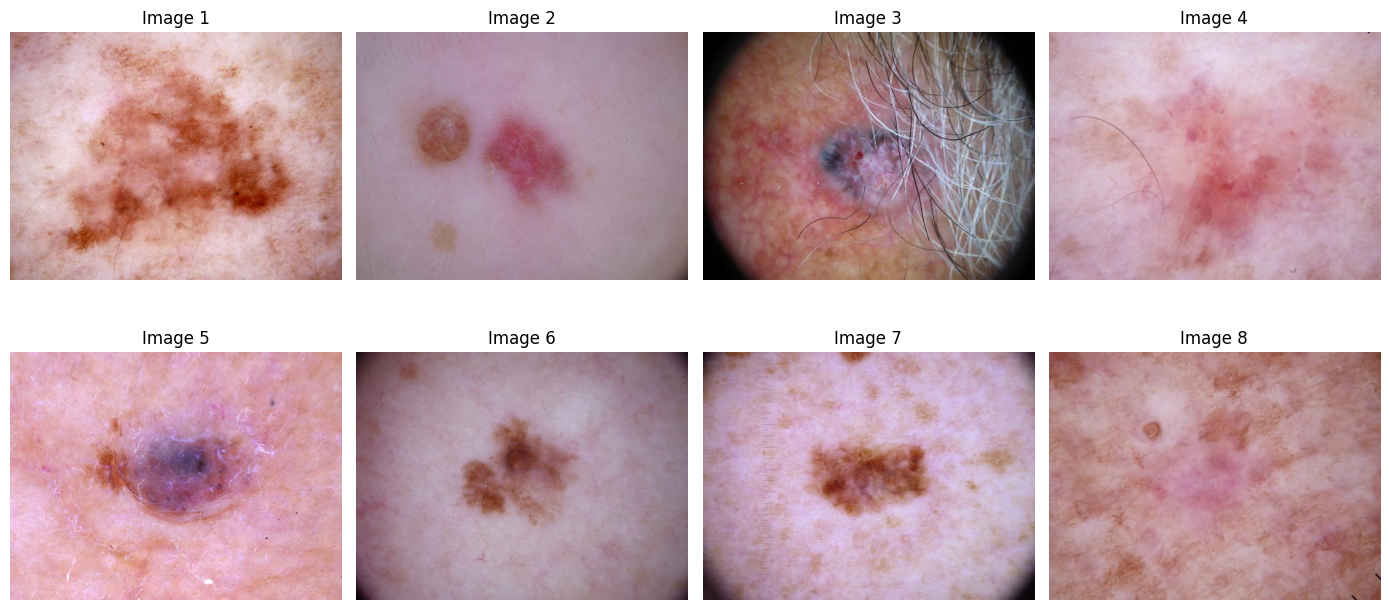


 Size of image:  (450, 600, 3)


In [6]:
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = f'/content/datasets/exp0/test/class_1/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()
print("\n Size of image: ", img.shape)

 Sets up a data loader using PyTorch and torchvision for handling datasets. Here's a summary of what each line does:

- `torch`: The core PyTorch library.
- `torchvision`: Provides datasets, models, and transformations for computer vision tasks.
- `DataLoader`: From `torch.utils.data`, loads datasets in batches.
- `datasets`: From `torchvision`, accesses standard datasets like MNIST, CIFAR-10, etc.
- `transforms`: From `torchvision`, contains image transformations.
- `tqdm`: Displays progress bars during iterations.

In [7]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm # progress bar

In machine learning, it is common to divide the dataset into three main parts: training set, validation set and test set. Here I explain each of them:

- **Train Set**: This dataset is used to train the model. That is, the model learns from this data by adjusting its parameters to minimise the loss function. The model is iteratively fitted to this data set during training, using optimisation techniques such as gradient descent. Generally, the training set is the largest, as an adequate amount of data is required for the model to learn meaningful patterns.
- **Test Set**: After training the model with the training set, the test set is used to adjust the hyperparameters of the model and evaluate its performance. The test set is used to select the best model among several possible configurations, avoiding overfitting to the validation set. This dataset is used to adjust the model architecture, learning rate or other hyperparameters, in order to obtain a generalisable model.
- **Validation Set**: This data set is used to evaluate the final performance of the model after it has been trained and evaluated. The test set is essentially a stand-alone data set that the model has not seen during training or evaluation. It provides an objective estimate of the model's performance on unseen data and helps assess its ability to generalise to new samples.

It is a good practice to normalize both the training set and the validation set in the same way. This ensures that the data are on the same scale and distribution, which can help the model converge more quickly during training and make more consistent predictions during evaluation.

It is important to remember that when normalizing the data, you need to calculate the mean and standard deviation only on the training set and then apply those same statistics to the validation set. This is because the validation set should simulate "new" or "unknown" data for the model, so it should not be used to calculate any normalization statistics.

Therefore, after calculating the mean and standard deviation on the training set, you can normalize both the training set and the validation set as follows:

1. Calculate the mean and standard deviation on the training set.
2. Normalize the training set using these statistics.
3. Normalize the validation set using the same statistics calculated on the training set.



In [8]:
# 1. Calculate the mean and standard deviation on the training set.
# train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
test_dir  = "/content/datasets/exp0/test/"
val_dir   = "/content/datasets/exp0/val/"

# transform to calculate mean and standard desviation
transform = transforms.Compose([
    transforms.ToTensor()  # transform images to tensor
])

# Load the ImageFolder dataset and apply the transformation
dataset = datasets.ImageFolder(root= train_dir, transform=transform)

# it's better to use a loader to retrieve images (tensors)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables to store the sum of pixel values and
# standard deviation.
# These variables are set to floating-point zeros to ensure
# accurate calculations.
mean_sum = 0.0
std_sum = 0.0
total_samples = 0

# Iterates over the data loader (loader),
# calculates the mean and standard deviation across all channels
# for each batch(0) and spatial dimensions (height(2) and width(3))
for images, _ in loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])
    total_samples += 1

mean = mean_sum / total_samples
std = std_sum / total_samples

print("Total train samples:", total_samples)
print("Mean:", mean)
print("Std:", std)

Total train samples: 2700
Mean: tensor([0.7513, 0.5535, 0.5788])
Std: tensor([0.0921, 0.1196, 0.1349])


In [ ]:
# 2. Normalize the training set using these statistics.


train_set = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

# 3. Normalize the test and validation set using the same statistics
# calculated on the training set.
test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)



print(f"Length of Train Data :{len(train_set)}")
print(f"Length of Test Data : {len(test_set)}")
print(f"Length of Validation Data : {len(val_set)}")

classes = train_set.classes
print('Classes: ', classes)



Length of Train Data :2700
Length of Test Data : 600
Length of Validation Data : 300
Classes:  ['class_0', 'class_1']


The train set is unmodified in size because `transform()` transform the data but it don't augment the dataset

Let us show one example for each class, for fun. As we've transformed the image by normalizing it, we should undo the transformation before visualizing the image.

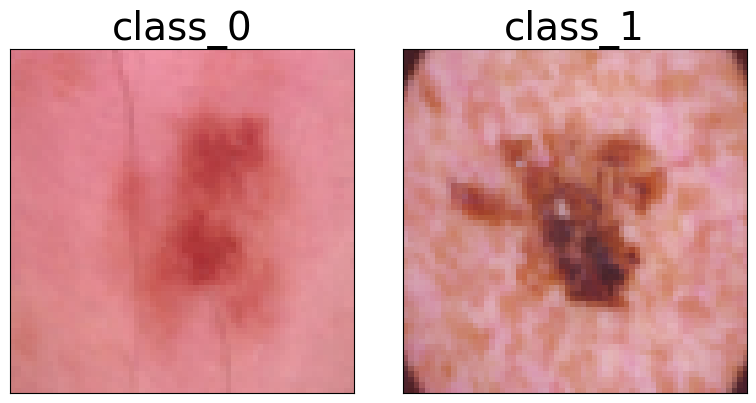

In [ ]:
inv_normalize = transforms.Normalize(
  mean= [-m/s for m, s in zip(mean, std)],
  std= [1/s for s in std]
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*4,1*4), subplot_kw={'facecolor': "#ebf5ff"})

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[i], fontsize=28)
  img = next(img for img,label in train_set if label == i)
  #ax.imshow(img.permute(1,2,0)) # for normalized channels
  ax.imshow(inv_normalize(img).permute(1,2,0)) # for unnormalized

fig.tight_layout()

We are going to define some training parameters for the network, such as the number of batches, epochs, and classes in the dataset.

In [ ]:
# batch size defines how many training or testing samples
# to use in a single iteration
batch_size = 32
# epochs define the number of iterations
epochs = 100
# num_classes define the number of the class
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


We define the train and test loaders for the training loop.

In [ ]:
# Create dataloaders object for training/test loop.

train_dataloader = DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2)

test_dataloader = DataLoader(
  test_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)

Or we can display all images and its ground truth from a random batch.

In [ ]:
# We define a small function to determine the columns and rows needed
# for a given number of images.
def rows_cols(input):

    divisors = []

    # Realize a little operation with input
    # in order to determine divisors for input
    for i in range(1, input+1): # not divide by 0
        if input % i == 0:
            divisors.append(i)

    # divisors list size
    n = len(divisors)

    # If the size is odd, the element in the middle is the median value.
    if n % 2 != 0:
        median_index = (n - 1) // 2
        rows = divisors[median_index]
    # If the size is even, the two elements in the middle are equal
    else:
        median_index1 = n // 2 - 1
        rows = divisors[median_index1]

    cols = int(input/rows)
    return rows, cols


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


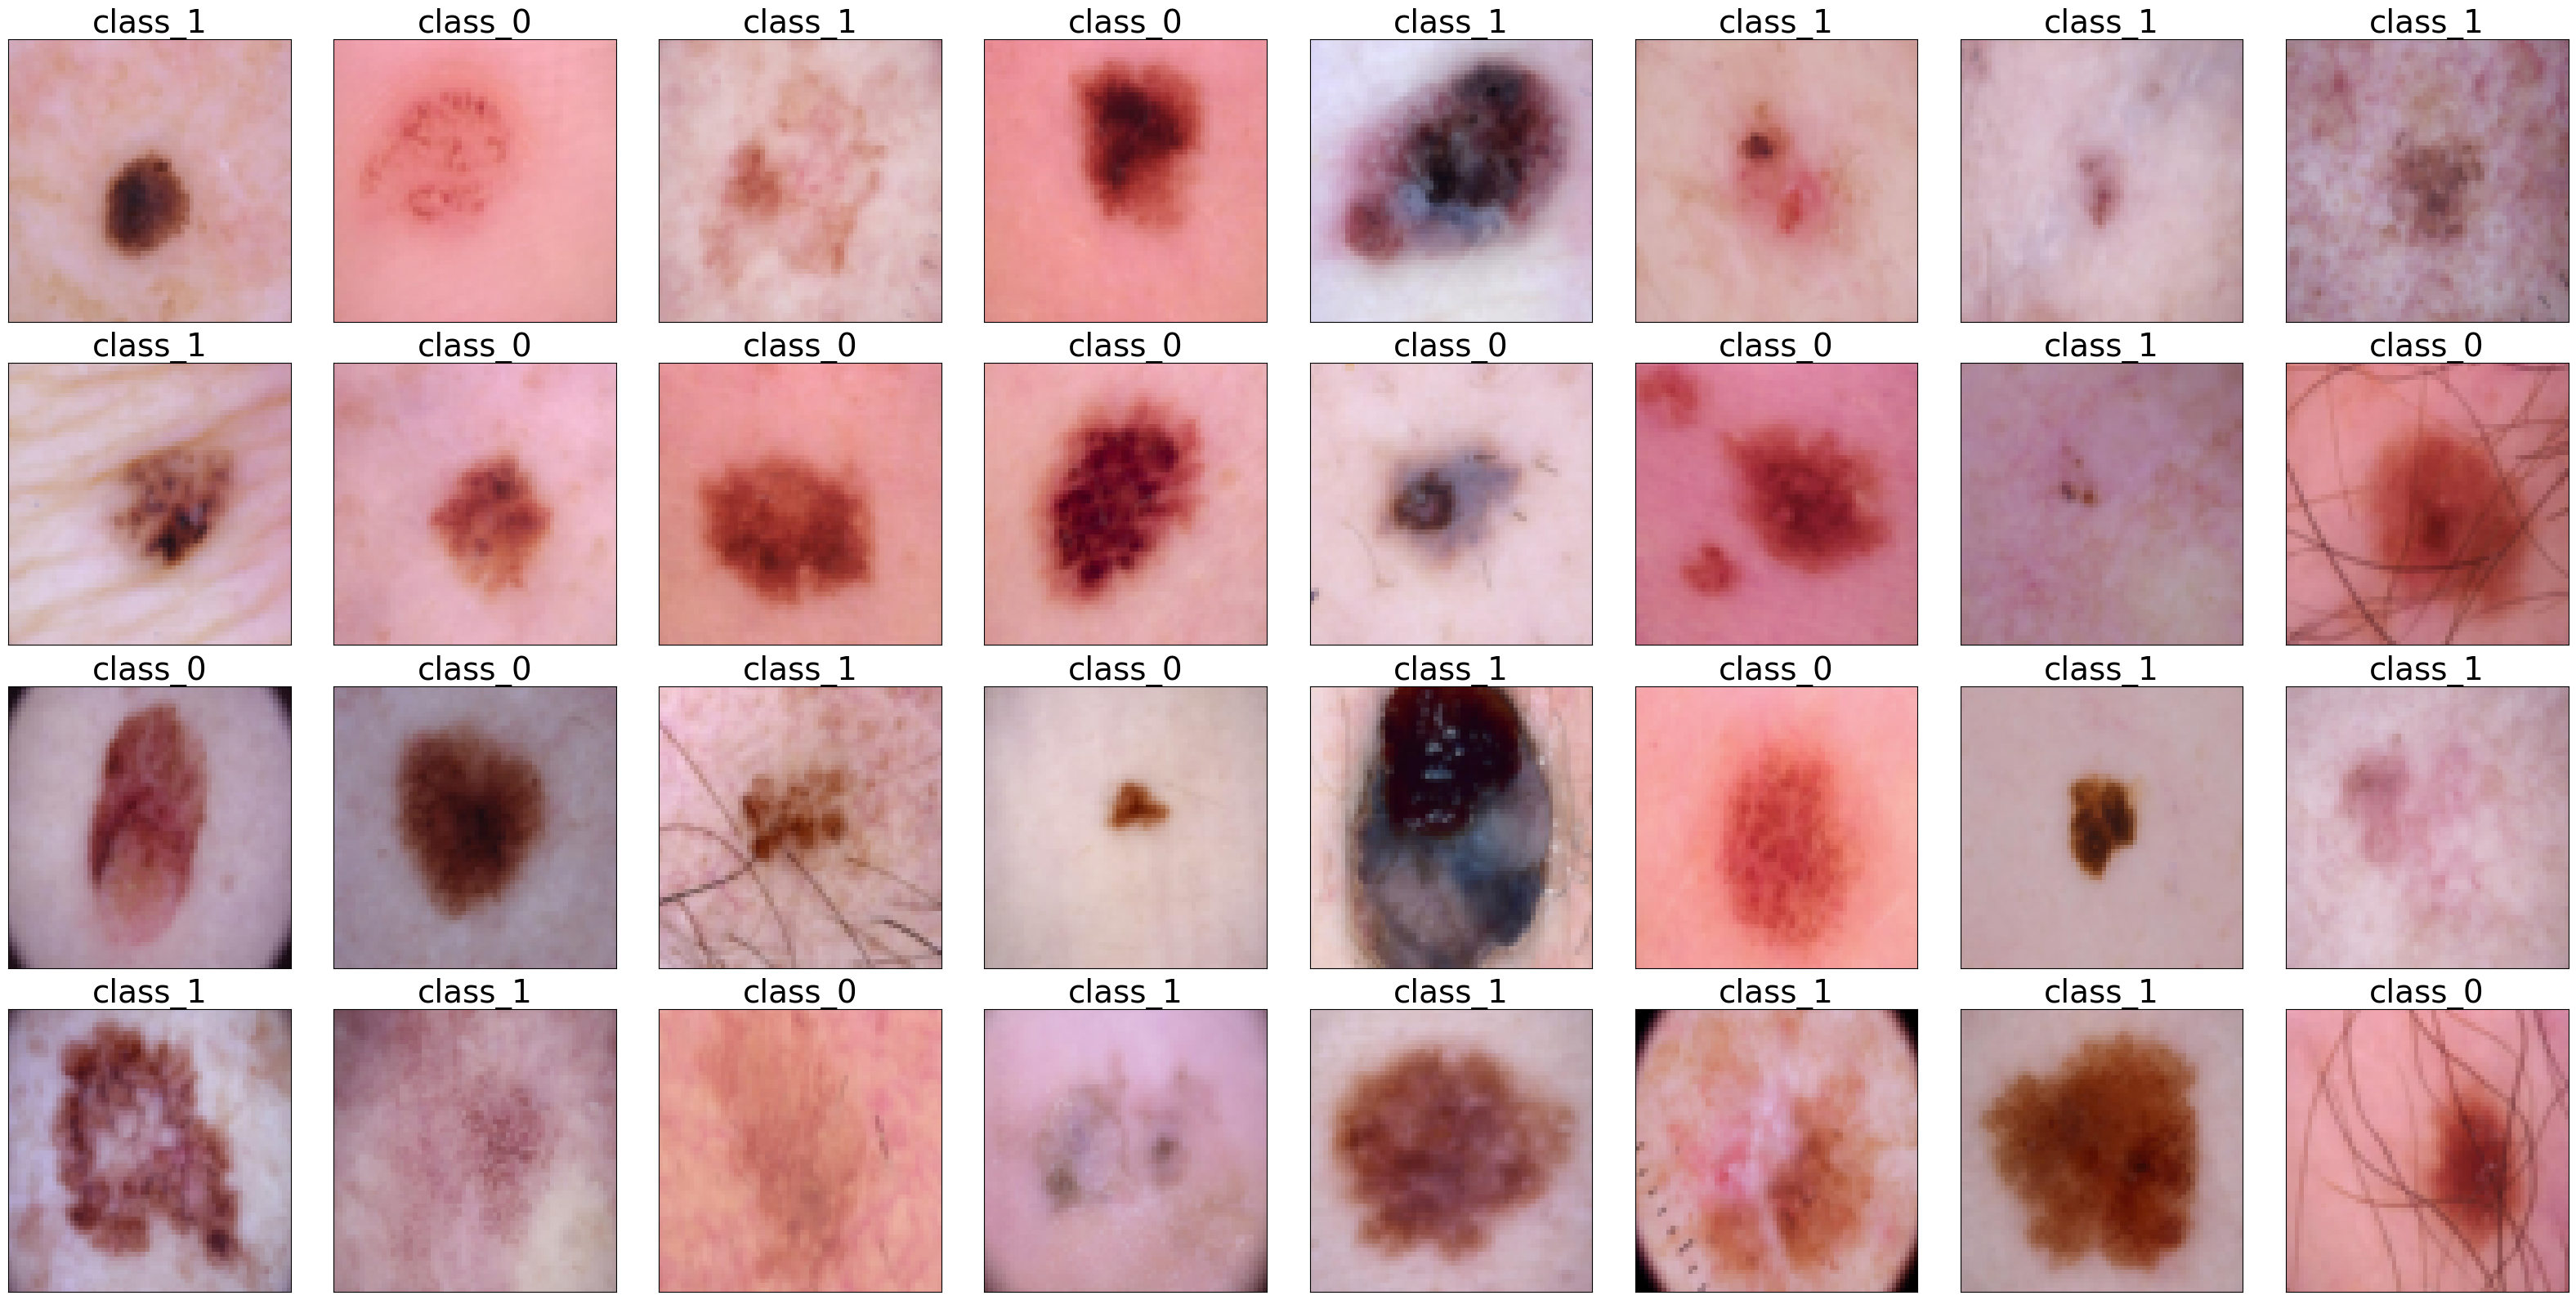

In [ ]:
import itertools
import random
import os

nrows,ncols = rows_cols(batch_size)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4), subplot_kw={'facecolor': "#ebf5ff"})
rb_index = random.randint(0, len(train_dataloader))

# Obtener el batch correspondiente al índice aleatorio
imgs, labels = next(itertools.islice(train_dataloader, rb_index, rb_index+1))

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[labels[i]], fontsize=28)
  #ax.imshow(imgs[i].permute(1,2,0)) # for unnormalized
  ax.imshow(inv_normalize(imgs[i]).permute(1,2,0)) # for unnormalized

fig.tight_layout()




### 2. Define a [Convolutional Neural Network](https://pytorch.org/docs/stable/nn.html)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

The output volume of a convolutional layer is determined by several factors, including the kernel size, padding, stride, and the dimensions of the input tensor.

For the `nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)` layer, let's assume the input has a size of `(batch_size, 32, H, W)`, where `batch_size` is the batch size, `32` is the number of input channels (feature maps), `H` is the height of the image, and `W` is the width of the image.

The output size is calculated using the following formula:

$$
\text{Output} = \left\lfloor \frac{{\text{Input} + 2 \times \text{padding} - \text{kernel_size}}}{{\text{stride}}} \right\rfloor + 1
$$

Substituting the values for this layer:

- `Input`: (32, H, W) (32 input channels)
- `padding`: 1 (padding=1)
- `kernel_size`: 3 (kernel_size=3)
- `stride`: 1 (stride=1)

Then, the calculation would be:

$$
\text{Output} = \left\lfloor \frac{{32 + 2 \times 1 - 3}}{1} \right\rfloor + 1 = \left\lfloor \frac{{32}}{1} \right\rfloor + 1 = 32
$$

Therefore, the output will have a size of `(batch_size, 64, 32, 32)`, meaning that for each sample in the batch, there will be 64 feature maps of size 32x32.

In [ ]:
# Large Model
class myCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            # Layer 1: Conv2d
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 2: Conv2d
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 3: MaxPool2d
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Layer 4: Conv2d
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5: Conv2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 6: MaxPool2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Layer 7: Conv2d
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 8: Conv2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 9: MaxPool2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Layer 10: Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 11: Linear
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.ReLU(),

            # Layer 12: Linear
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.ReLU(),

            # Layer 13: Linear
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )

    def forward(self, xb):
        return self.network(xb)



In this modified version:

- I added Batch Normalization layers (`nn.BatchNorm2d` for convolutional layers and `nn.BatchNorm1d` for fully connected layers) after each activation function to stabilize and accelerate training.
- Dropout layers (`nn.Dropout2d` for convolutional layers and `nn.Dropout` for fully connected layers) were introduced after each activation function to prevent overfitting.
- I adjusted the input size of the first fully connected layer (`nn.Linear`) based on the output size of the previous layer's `Flatten` operation.
- The dropout rate for fully connected layers was set to 0.5, which is a common value for dropout rates in practice.

Feel free to adjust the hyperparameters, such as dropout rates or batch normalization momentum, to further optimize the model's performance based on your specific dataset and training settings. Additionally, you may experiment with different optimizer configurations and learning rate schedules to find the best training setup for your model.

In [ ]:
class myImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            # Layer 1: Convolutional
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Add Batch Normalization
            nn.ReLU(),

            # Layer 2: Convolutional
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Add Batch Normalization
            nn.ReLU(),

            # Max Pooling
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Dropout
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 64, 32, 32)
            nn.Dropout2d(0.25),

            # Layer 3: Convolutional
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add Batch Normalization
            nn.ReLU(),

            # Layer 4: Convolutional
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add Batch Normalization
            nn.ReLU(),

            # Max Pooling
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Dropout
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 128, 16, 16)
            nn.Dropout2d(0.25),

            # Layer 5: Convolutional
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add Batch Normalization
            nn.ReLU(),

            # Layer 6: Convolutional
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add Batch Normalization
            nn.ReLU(),

            # Max Pooling
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Dropout
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 256, 8, 8)
            nn.Dropout2d(0.25),

            # Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 7: Fully Connected (Linear)
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.BatchNorm1d(128),  # Add Batch Normalization for fully connected layers
            nn.ReLU(),

            # Dropout
            # Input: (batch_size, 128)
            # Output: (batch_size, 128)
            nn.Dropout(0.5),

            # Layer 8: Fully Connected (Linear)
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  # Add Batch Normalization for fully connected layers
            nn.ReLU(),

            # Dropout
            # Input: (batch_size, 64)
            # Output: (batch_size, 64)
            nn.Dropout(0.5),

            # Layer 9: Fully Connected (Linear)
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = myCNN().to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

print(model)


Using cuda device
myCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear

In [ ]:
from torchsummary import summary

summary(model, (3,64,64)) # input = [3,64,64]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
!pip install -q torchviz

  Preparing metadata (setup.py) ... done


In [ ]:
from torchviz import make_dot

# Creamos un tensor de entrada
x = torch.randn(batch_size, 3, 64, 64, device=device)

# Obtenemos la salida de la red neuronal
y = model(x)

# Visualizamos el grafo de cálculo de la red neuronal
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render(filename='myCNN', format='png')

'myCNN.png'

### 3. Define a Loss function and optimizer
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html). Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
# Define your optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001 )
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 4. Train the network


In [ ]:
print (len(train_dataloader.dataset)) #number of images from dataset
print (len(train_dataloader)) # number of images/batch_size (or number of batches)

2700
85


In a training loop, a training dataset is used. This dataset consists of input examples (for example, images in an image classification problem) and their corresponding labels or desired outputs (for example, class labels associated with each image). The purpose of the training loop is to iterate over this dataset to update the model's weights during training.

The training dataset is used to adjust the model's parameters, i.e., the weights of the connections between the neurons of the neural network. During each iteration of the training loop, the model calculates predictions for a batch of input examples, compares those predictions with the true labels using a loss function, and then adjusts the model's weights to minimize this loss function.

The metrics used to determine good learning depend on the specific problem you are addressing. Some common metrics include:

1. **Accuracy**: It is the proportion of examples correctly classified by the model with respect to the total number of examples.

2. **Loss**: It is a measure of how well the model is doing in its predictions. Loss functions typically assign a numerical value to the difference between the model's predictions and the true labels. The goal of training is to minimize this loss.

3. **Class-wise Accuracy**: In classification problems with multiple classes, it can be useful to examine the model's accuracy for each class individually.

4. **Training Time**: The amount of time needed to train the model can be an important metric, especially in real-time applications.

These metrics are used to evaluate the model's performance during training and validation, and to make decisions about the model's architecture, hyperparameters, and other aspects of the training process.

In [ ]:
def train(dataloader, model, criterion, optimizer):
  running_loss, corrects, current = 0, 0, 0
  size = len(dataloader.dataset) # number images from dataset
  print(f"Training:")
  model.train()
  loop = tqdm(train_dataloader) # progressive bar
  for batch, (X, y) in enumerate(loop):
    # take data (X) and label (y) from a batch
    X, y = X.to(device), y.to(device)

    # forward pass (Compute prediction error)
    preds = model(X)
    loss = criterion(preds, y)

    # backpropagation
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()
    optimizer.step()        # Does the "update weights"

    # calculate metrics

    # 1. loss.item() contains the loss of entire mini-batch converted to scalar
    running_loss += loss.item() #
    # 2. current image (last image in the batch) for progressive bar
    current += len(X)
    # 3. From the predictions, I select the index (class) of the one with
    # the highest value and compare it with the label (class). The boolean value
    # is converted into a float (true becomes 1, false becomes 0), and all are
    # summed up. Finally, 'item' converts them into a scalar value.
    # This way, 'corrects' reflects the number of correct predictions (accuracy)
    corrects += (preds.argmax(1) == y).type(torch.float).sum().item()
    # 4. running loss is the sum of our loss. Training loss is a running average
    # through batches
    training_loss = running_loss/(batch+1)
    # 5. Corrects

    training_accuracy = corrects/current

    loop.set_description(f'[{epoch + 1}/{epochs} epochs, {current:>5d}/{len(train_dataloader.dataset):>5d} data]')

    loop.set_postfix(Training_Loss=training_loss, Accuracy=f'{100*corrects/current:>0.1f}%')

  return training_loss, training_accuracy

In [ ]:
def test(dataloader, model, criterion):
  size = len(dataloader.dataset) # number images from dataset to evaluate
  num_batches = len(dataloader)  # number of batches

  # Evaluation (test)) Mode
  model.eval()

  test_loss, corrects = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      # prediction for a dataset not used in training
      # compute prediction error and number of corrects
      # through batches
      preds = model(X)
      test_loss += criterion(preds, y).item()
      corrects += (preds.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  corrects /= size
  print(f"Test: \n Accuracy: {(100*corrects):>0.1f}%, Test_Loss: {test_loss:>8f} \n")

  return test_loss, corrects

In [ ]:
loss_train_history = []
accuracy_train_history = []
loss_test_history = []
accuracy_test_history = []
for epoch in range(epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_test,acc_test= test(test_dataloader, model, criterion)
  loss_test_history.append(loss_test)
  accuracy_test_history.append(acc_test)
print("Done!. Finished Training")

Training:


  0%|          | 0/85 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[1/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.50it/s, Accuracy=50.0%, Training_Loss=0.694]


Test: 
 Accuracy: 50.0%, Test_Loss: 0.693510 

Training:


[2/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.02it/s, Accuracy=50.0%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, Test_Loss: 0.693165 

Training:


[3/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.30it/s, Accuracy=50.0%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, Test_Loss: 0.692927 

Training:


[4/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.11it/s, Accuracy=54.6%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, Test_Loss: 0.692835 

Training:


[5/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.28it/s, Accuracy=54.0%, Training_Loss=0.693]


Test: 
 Accuracy: 54.3%, Test_Loss: 0.692611 

Training:


[6/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.91it/s, Accuracy=57.6%, Training_Loss=0.693]


Test: 
 Accuracy: 64.5%, Test_Loss: 0.692428 

Training:


[7/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.06it/s, Accuracy=61.9%, Training_Loss=0.692]


Test: 
 Accuracy: 64.0%, Test_Loss: 0.692208 

Training:


[8/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.15it/s, Accuracy=55.4%, Training_Loss=0.692]


Test: 
 Accuracy: 70.5%, Test_Loss: 0.691878 

Training:


[9/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.86it/s, Accuracy=52.7%, Training_Loss=0.692]


Test: 
 Accuracy: 50.2%, Test_Loss: 0.691519 

Training:


[10/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.03it/s, Accuracy=67.6%, Training_Loss=0.691]


Test: 
 Accuracy: 67.7%, Test_Loss: 0.690705 

Training:


[11/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.20it/s, Accuracy=66.7%, Training_Loss=0.69]


Test: 
 Accuracy: 69.8%, Test_Loss: 0.689498 

Training:


[12/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.95it/s, Accuracy=63.8%, Training_Loss=0.689]


Test: 
 Accuracy: 68.3%, Test_Loss: 0.687356 

Training:


[13/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.18it/s, Accuracy=68.0%, Training_Loss=0.686]


Test: 
 Accuracy: 70.2%, Test_Loss: 0.682964 

Training:


[14/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.11it/s, Accuracy=66.3%, Training_Loss=0.68]


Test: 
 Accuracy: 71.2%, Test_Loss: 0.675388 

Training:


[15/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.78it/s, Accuracy=68.6%, Training_Loss=0.668]


Test: 
 Accuracy: 70.7%, Test_Loss: 0.657588 

Training:


[16/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.09it/s, Accuracy=68.3%, Training_Loss=0.639]


Test: 
 Accuracy: 70.3%, Test_Loss: 0.604529 

Training:


[17/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.06it/s, Accuracy=68.4%, Training_Loss=0.585]


Test: 
 Accuracy: 70.8%, Test_Loss: 0.560408 

Training:


[18/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.65it/s, Accuracy=70.3%, Training_Loss=0.56]


Test: 
 Accuracy: 71.2%, Test_Loss: 0.548922 

Training:


[19/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.59it/s, Accuracy=70.4%, Training_Loss=0.55]


Test: 
 Accuracy: 71.8%, Test_Loss: 0.545245 

Training:


[20/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.91it/s, Accuracy=71.2%, Training_Loss=0.536]


Test: 
 Accuracy: 72.7%, Test_Loss: 0.534445 

Training:


[21/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.15it/s, Accuracy=71.7%, Training_Loss=0.534]


Test: 
 Accuracy: 71.3%, Test_Loss: 0.537195 

Training:


[22/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.10it/s, Accuracy=71.5%, Training_Loss=0.532]


Test: 
 Accuracy: 72.2%, Test_Loss: 0.533680 

Training:


[23/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.36it/s, Accuracy=72.1%, Training_Loss=0.523]


Test: 
 Accuracy: 72.5%, Test_Loss: 0.524262 

Training:


[24/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.64it/s, Accuracy=71.9%, Training_Loss=0.526]


Test: 
 Accuracy: 72.7%, Test_Loss: 0.533359 

Training:


[25/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.02it/s, Accuracy=72.5%, Training_Loss=0.515]


Test: 
 Accuracy: 73.0%, Test_Loss: 0.515803 

Training:


[26/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.82it/s, Accuracy=72.8%, Training_Loss=0.507]


Test: 
 Accuracy: 72.8%, Test_Loss: 0.512167 

Training:


[27/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.47it/s, Accuracy=73.1%, Training_Loss=0.51]


Test: 
 Accuracy: 73.7%, Test_Loss: 0.507950 

Training:


[28/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.41it/s, Accuracy=72.9%, Training_Loss=0.504]


Test: 
 Accuracy: 74.2%, Test_Loss: 0.499617 

Training:


[29/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.08it/s, Accuracy=73.0%, Training_Loss=0.502]


Test: 
 Accuracy: 74.3%, Test_Loss: 0.490879 

Training:


[30/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.29it/s, Accuracy=73.0%, Training_Loss=0.499]


Test: 
 Accuracy: 74.3%, Test_Loss: 0.497446 

Training:


[31/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.07it/s, Accuracy=74.0%, Training_Loss=0.493]


Test: 
 Accuracy: 74.5%, Test_Loss: 0.482747 

Training:


[32/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.68it/s, Accuracy=73.8%, Training_Loss=0.49]


Test: 
 Accuracy: 75.2%, Test_Loss: 0.477596 

Training:


[33/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.01it/s, Accuracy=73.1%, Training_Loss=0.5]


Test: 
 Accuracy: 74.3%, Test_Loss: 0.488355 

Training:


[34/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.15it/s, Accuracy=74.2%, Training_Loss=0.489]


Test: 
 Accuracy: 74.7%, Test_Loss: 0.500627 

Training:


[35/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.64it/s, Accuracy=74.4%, Training_Loss=0.491]


Test: 
 Accuracy: 74.2%, Test_Loss: 0.479236 

Training:


[36/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.50it/s, Accuracy=74.4%, Training_Loss=0.485]


Test: 
 Accuracy: 75.3%, Test_Loss: 0.472003 

Training:


[37/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.10it/s, Accuracy=74.9%, Training_Loss=0.483]


Test: 
 Accuracy: 75.5%, Test_Loss: 0.488526 

Training:


[38/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.19it/s, Accuracy=74.2%, Training_Loss=0.483]


Test: 
 Accuracy: 74.2%, Test_Loss: 0.495608 

Training:


[39/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.88it/s, Accuracy=74.2%, Training_Loss=0.483]


Test: 
 Accuracy: 74.7%, Test_Loss: 0.474389 

Training:


[40/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.40it/s, Accuracy=75.4%, Training_Loss=0.474]


Test: 
 Accuracy: 75.7%, Test_Loss: 0.468952 

Training:


[41/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.95it/s, Accuracy=74.9%, Training_Loss=0.479]


Test: 
 Accuracy: 74.7%, Test_Loss: 0.462714 

Training:


[42/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.75it/s, Accuracy=75.3%, Training_Loss=0.471]


Test: 
 Accuracy: 75.3%, Test_Loss: 0.478294 

Training:


[43/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.15it/s, Accuracy=74.9%, Training_Loss=0.467]


Test: 
 Accuracy: 75.8%, Test_Loss: 0.464474 

Training:


[44/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.17it/s, Accuracy=75.8%, Training_Loss=0.467]


Test: 
 Accuracy: 75.5%, Test_Loss: 0.461287 

Training:


[45/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.27it/s, Accuracy=74.8%, Training_Loss=0.473]


Test: 
 Accuracy: 75.7%, Test_Loss: 0.465968 

Training:


[46/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.99it/s, Accuracy=76.2%, Training_Loss=0.463]


Test: 
 Accuracy: 76.0%, Test_Loss: 0.458904 

Training:


[47/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.68it/s, Accuracy=75.8%, Training_Loss=0.461]


Test: 
 Accuracy: 77.0%, Test_Loss: 0.460457 

Training:


[48/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.93it/s, Accuracy=75.7%, Training_Loss=0.463]


Test: 
 Accuracy: 76.5%, Test_Loss: 0.478627 

Training:


[49/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.96it/s, Accuracy=75.8%, Training_Loss=0.462]


Test: 
 Accuracy: 75.8%, Test_Loss: 0.485512 

Training:


[50/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.91it/s, Accuracy=76.0%, Training_Loss=0.459]


Test: 
 Accuracy: 75.8%, Test_Loss: 0.468585 

Training:


[51/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.68it/s, Accuracy=76.7%, Training_Loss=0.457]


Test: 
 Accuracy: 76.2%, Test_Loss: 0.464010 

Training:


[52/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.11it/s, Accuracy=76.4%, Training_Loss=0.457]


Test: 
 Accuracy: 76.7%, Test_Loss: 0.465707 

Training:


[53/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.11it/s, Accuracy=74.5%, Training_Loss=0.473]


Test: 
 Accuracy: 77.2%, Test_Loss: 0.451172 

Training:


[54/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.92it/s, Accuracy=75.6%, Training_Loss=0.459]


Test: 
 Accuracy: 76.0%, Test_Loss: 0.470798 

Training:


[55/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.77it/s, Accuracy=75.0%, Training_Loss=0.457]


Test: 
 Accuracy: 77.0%, Test_Loss: 0.460332 

Training:


[56/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.00it/s, Accuracy=76.5%, Training_Loss=0.451]


Test: 
 Accuracy: 77.0%, Test_Loss: 0.449307 

Training:


[57/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.10it/s, Accuracy=76.8%, Training_Loss=0.449]


Test: 
 Accuracy: 77.3%, Test_Loss: 0.463539 

Training:


[58/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.95it/s, Accuracy=77.2%, Training_Loss=0.444]


Test: 
 Accuracy: 77.2%, Test_Loss: 0.457157 

Training:


[59/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.89it/s, Accuracy=76.6%, Training_Loss=0.446]


Test: 
 Accuracy: 77.5%, Test_Loss: 0.445607 

Training:


[60/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.95it/s, Accuracy=76.0%, Training_Loss=0.457]


Test: 
 Accuracy: 76.5%, Test_Loss: 0.476249 

Training:


[61/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.29it/s, Accuracy=77.6%, Training_Loss=0.443]


Test: 
 Accuracy: 77.7%, Test_Loss: 0.463183 

Training:


[62/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.55it/s, Accuracy=77.5%, Training_Loss=0.435]


Test: 
 Accuracy: 75.7%, Test_Loss: 0.448391 

Training:


[63/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.21it/s, Accuracy=77.3%, Training_Loss=0.435]


Test: 
 Accuracy: 78.7%, Test_Loss: 0.446542 

Training:


[64/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.07it/s, Accuracy=77.6%, Training_Loss=0.434]


Test: 
 Accuracy: 78.7%, Test_Loss: 0.447498 

Training:


[65/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.17it/s, Accuracy=78.6%, Training_Loss=0.427]


Test: 
 Accuracy: 76.8%, Test_Loss: 0.452547 

Training:


[66/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.76it/s, Accuracy=77.8%, Training_Loss=0.429]


Test: 
 Accuracy: 79.0%, Test_Loss: 0.443298 

Training:


[67/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.81it/s, Accuracy=76.1%, Training_Loss=0.464]


Test: 
 Accuracy: 75.5%, Test_Loss: 0.469623 

Training:


[68/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.00it/s, Accuracy=78.3%, Training_Loss=0.434]


Test: 
 Accuracy: 77.3%, Test_Loss: 0.456016 

Training:


[69/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.64it/s, Accuracy=78.0%, Training_Loss=0.429]


Test: 
 Accuracy: 79.3%, Test_Loss: 0.452329 

Training:


[70/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.71it/s, Accuracy=78.9%, Training_Loss=0.426]


Test: 
 Accuracy: 76.8%, Test_Loss: 0.455030 

Training:


[71/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.92it/s, Accuracy=78.6%, Training_Loss=0.422]


Test: 
 Accuracy: 79.8%, Test_Loss: 0.435204 

Training:


[72/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.08it/s, Accuracy=78.1%, Training_Loss=0.431]


Test: 
 Accuracy: 78.0%, Test_Loss: 0.450301 

Training:


[73/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.21it/s, Accuracy=79.0%, Training_Loss=0.421]


Test: 
 Accuracy: 79.0%, Test_Loss: 0.437266 

Training:


[74/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.65it/s, Accuracy=79.1%, Training_Loss=0.413]


Test: 
 Accuracy: 79.5%, Test_Loss: 0.452071 

Training:


[75/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.66it/s, Accuracy=79.8%, Training_Loss=0.419]


Test: 
 Accuracy: 78.8%, Test_Loss: 0.449952 

Training:


[76/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.01it/s, Accuracy=80.0%, Training_Loss=0.411]


Test: 
 Accuracy: 79.3%, Test_Loss: 0.441961 

Training:


[77/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.31it/s, Accuracy=78.9%, Training_Loss=0.413]


Test: 
 Accuracy: 77.7%, Test_Loss: 0.445405 

Training:


[78/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.27it/s, Accuracy=78.7%, Training_Loss=0.42]


Test: 
 Accuracy: 78.7%, Test_Loss: 0.454379 

Training:


[79/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.61it/s, Accuracy=79.6%, Training_Loss=0.409]


Test: 
 Accuracy: 76.7%, Test_Loss: 0.457858 

Training:


[80/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.50it/s, Accuracy=79.0%, Training_Loss=0.413]


Test: 
 Accuracy: 78.7%, Test_Loss: 0.442565 

Training:


[81/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.13it/s, Accuracy=80.7%, Training_Loss=0.401]


Test: 
 Accuracy: 78.5%, Test_Loss: 0.454421 

Training:


[82/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.41it/s, Accuracy=80.1%, Training_Loss=0.404]


Test: 
 Accuracy: 79.3%, Test_Loss: 0.439779 

Training:


[83/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.14it/s, Accuracy=80.7%, Training_Loss=0.399]


Test: 
 Accuracy: 77.5%, Test_Loss: 0.468285 

Training:


[84/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.78it/s, Accuracy=80.1%, Training_Loss=0.4]


Test: 
 Accuracy: 77.5%, Test_Loss: 0.446424 

Training:


[85/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.81it/s, Accuracy=81.2%, Training_Loss=0.39]


Test: 
 Accuracy: 78.3%, Test_Loss: 0.440179 

Training:


[86/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.96it/s, Accuracy=80.2%, Training_Loss=0.402]


Test: 
 Accuracy: 78.7%, Test_Loss: 0.453561 

Training:


[87/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.88it/s, Accuracy=80.6%, Training_Loss=0.391]


Test: 
 Accuracy: 79.5%, Test_Loss: 0.450521 

Training:


[88/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.24it/s, Accuracy=81.2%, Training_Loss=0.387]


Test: 
 Accuracy: 78.8%, Test_Loss: 0.446676 

Training:


[89/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.87it/s, Accuracy=81.9%, Training_Loss=0.38]


Test: 
 Accuracy: 75.5%, Test_Loss: 0.489371 

Training:


[90/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.86it/s, Accuracy=81.8%, Training_Loss=0.39]


Test: 
 Accuracy: 78.3%, Test_Loss: 0.455560 

Training:


[91/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.86it/s, Accuracy=81.6%, Training_Loss=0.378]


Test: 
 Accuracy: 79.5%, Test_Loss: 0.448337 

Training:


[92/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.58it/s, Accuracy=82.1%, Training_Loss=0.372]


Test: 
 Accuracy: 77.5%, Test_Loss: 0.470411 

Training:


[93/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.44it/s, Accuracy=82.2%, Training_Loss=0.375]


Test: 
 Accuracy: 77.5%, Test_Loss: 0.455873 

Training:


[94/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.15it/s, Accuracy=81.7%, Training_Loss=0.379]


Test: 
 Accuracy: 76.2%, Test_Loss: 0.472160 

Training:


[95/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.95it/s, Accuracy=82.1%, Training_Loss=0.368]


Test: 
 Accuracy: 78.2%, Test_Loss: 0.441503 

Training:


[96/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.86it/s, Accuracy=81.6%, Training_Loss=0.373]


Test: 
 Accuracy: 79.2%, Test_Loss: 0.458093 

Training:


[97/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.42it/s, Accuracy=83.0%, Training_Loss=0.359]


Test: 
 Accuracy: 77.2%, Test_Loss: 0.459716 

Training:


[98/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.24it/s, Accuracy=83.6%, Training_Loss=0.353]


Test: 
 Accuracy: 79.0%, Test_Loss: 0.464505 

Training:


[99/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.38it/s, Accuracy=83.4%, Training_Loss=0.352]


Test: 
 Accuracy: 76.7%, Test_Loss: 0.477720 

Training:


[100/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.14it/s, Accuracy=82.7%, Training_Loss=0.364]


Test: 
 Accuracy: 77.2%, Test_Loss: 0.465337 

Done!. Finished Training


If your training process is oscillating and not improving accuracy, there could be several reasons for this issue. Here are some common ones and possible solutions:

1. **Learning rate too high or too low**: If the learning rate is too high, the optimization process may overshoot the optimal solution, causing oscillations. Conversely, if the learning rate is too low, the optimization process may get stuck in local minima. Try adjusting the learning rate. You can try reducing it gradually during training (learning rate scheduling) or using adaptive learning rate algorithms like Adam.

2. **Poor initialization**: The initial weights of the neural network could be poorly chosen, leading to oscillations. Try initializing the weights using different strategies, such as Xavier or He initialization.

3. **Overfitting**: If your model is too complex relative to the amount of training data, it may overfit, causing oscillations in performance. Regularization techniques like dropout or weight decay can help combat overfitting.

4. **Insufficient data augmentation**: If you're working with a small dataset, augmenting the data (e.g., by rotating, flipping, or scaling the images) can help the model generalize better and reduce oscillations.

5. **Model architecture**: The architecture of your neural network may not be suitable for the problem at hand. Experiment with different architectures, layer sizes, and activation functions to see if you can achieve better performance.

6. **Hyperparameter tuning**: Other hyperparameters such as batch size, number of layers, and optimizer choice could also affect the training process. Try experimenting with different values for these hyperparameters to find the best combination.

7. **Early stopping**: Implement early stopping based on validation performance to prevent overfitting and avoid wasting computational resources on training epochs that do not improve validation performance.

8. **Data imbalance**: If the classes in your dataset are imbalanced, the model may focus too much on the majority class and perform poorly on the minority class. Consider using techniques such as class weights or oversampling/undersampling to address this issue.

By systematically diagnosing and addressing these potential issues, you should be able to stabilize the training process and improve the accuracy of your model.

Thank you for providing the example. Based on the information you provided, it seems that the training accuracy is increasing steadily, indicating that the model is learning well from the training data. However, the test accuracy is not improving significantly, which suggests that the model might be overfitting to the training data.

Here are some suggestions to address this issue:

1. **Regularization**: Apply regularization techniques such as L2 regularization or dropout to prevent overfitting. Regularization penalizes large weights in the model, making it more robust to noise in the training data.

2. **Data Augmentation**: Increase the diversity of the training data by applying data augmentation techniques such as random rotations, translations, and flips. This can help the model generalize better to unseen data.

3. **Model Complexity**: Simplify the model architecture by reducing the number of parameters or layers. A simpler model may generalize better to the test data.

4. **Learning Rate Schedule**: Experiment with learning rate schedules such as reducing the learning rate over time (learning rate decay) to help the model converge to a better solution.

5. **Early Stopping**: Implement early stopping based on the validation performance to prevent the model from overfitting to the training data.

6. **Hyperparameter Tuning**: Fine-tune the hyperparameters of the model, such as the learning rate, batch size, and optimizer, to achieve better performance on the test data.

By applying these techniques and carefully monitoring the training and test performance, you should be able to improve the overall accuracy of your model.

If the training accuracy and training loss are satisfactory, but the test accuracy and test loss are poor, it indicates that your model is overfitting to the training data. Overfitting occurs when the model learns to memorize the training data rather than generalize to unseen data.

Here are some common reasons why overfitting might occur and potential solutions:

1. **Model Complexity**: Your model might be too complex relative to the amount of training data. As a result, it learns to fit the noise in the training data rather than capturing the underlying patterns. You can try simplifying your model architecture by reducing the number of parameters or layers.

2. **Insufficient Data**: If you have a small dataset, your model may not have enough examples to learn the underlying patterns effectively. Consider collecting more data if possible or using data augmentation techniques to artificially increase the size of your dataset.

3. **Regularization**: Regularization techniques such as dropout, L2 regularization, or early stopping can help prevent overfitting. Dropout randomly drops some neurons during training, which can prevent the model from relying too much on any single feature. L2 regularization penalizes large weights in the model, discouraging overfitting.

4. **Data Quality**: Poor quality or noisy data can lead to overfitting. Make sure your data is clean and free of errors. You can also consider preprocessing your data to remove outliers or irrelevant features.

5. **Validation Set**: Ensure that you're using a separate validation set to monitor the model's performance during training. Use the validation set to tune hyperparameters and detect overfitting early.

6. **Early Stopping**: Implement early stopping based on the validation performance to prevent the model from overfitting. Stop training when the validation loss starts to increase, indicating that the model is beginning to overfit.

7. **Ensemble Methods**: Instead of relying on a single model, you can use ensemble methods to combine the predictions of multiple models. Ensemble methods often generalize better than individual models and can reduce overfitting.

By addressing these potential causes of overfitting and experimenting with different techniques, you should be able to improve the generalization performance of your model on the test set. Remember to monitor both the training and validation performance closely to ensure that your model is learning effectively without overfitting to the training data.

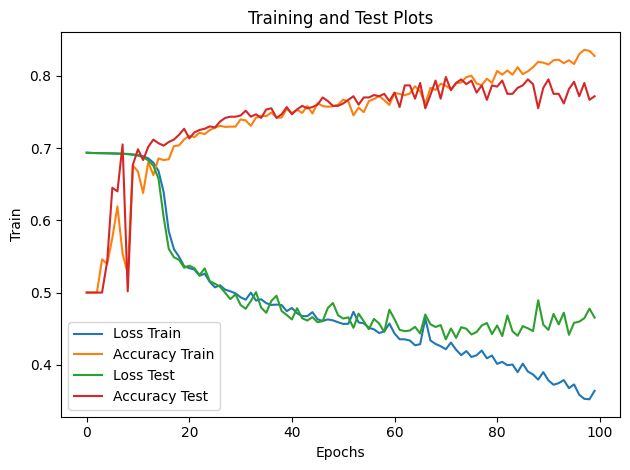

In [ ]:
fig, ax = plt.subplots()

ax.set_title('Training and Test Plots')
ax.plot(range(epochs), loss_train_history, label="Loss Train")
ax.plot(range(epochs), accuracy_train_history, label="Accuracy Train")
ax.plot(range(epochs), loss_test_history, label="Loss Test")
ax.plot(range(epochs), accuracy_test_history, label="Accuracy Test")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

torch.save(model.state_dict(), "myCNN.pth")

# Downloading/uploading files to/from your local file system (interactive way)

The files.download method will prompt the browser to download the file to your local computer.

In [ ]:
from google.colab import files

files.download('myCNN.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving myCNN.pth to myCNN (1).pth


# Early Stopping

Early stopping is a technique used in machine learning model training to halt training before the model begins to overfit the training data. This is done by monitoring a metric of interest on the validation set and stopping training when the metric ceases to improve for a certain number of consecutive epochs.

You can use the Python standard library os to create a directory named "train" in the current directory and then save the trained models (pth) in that directory. Here's an example of how to do it:


In [ ]:
# Current directory
current_dir = os.getcwd()

# Path to the "train" directory
train_dir = os.path.join(current_dir, 'train')

# Check if the "train" directory already exists
if not os.path.exists(train_dir):
    # Create the "train" directory if it doesn't exist
    os.makedirs(train_dir)

# Save the trained model in the "train" directory
model_path = os.path.join(train_dir, 'model_name.pth')
torch.save(model.state_dict(), model_path)

[Checkpoints and Early Stopping](https://machinelearningmastery.com/managing-a-pytorch-training-process-with-checkpoints-and-early-stopping/)

Application checkpointing is a fault tolerance technique. In this approach, a snapshot of the state of the system is taken in case of system failure. If there is a problem, you can resume from the snapshot. The checkpoint may be used directly or as the starting point for a new run, picking up where it left off. When training deep learning models, the checkpoint captures the weights of the model. These weights can be used to make predictions as-is or as the basis for ongoing training.

PyTorch does not provide any function for checkpointing but it has functions for retrieving and restoring weights of a model. So you can implement checkpointing logic with them. Let’s make a checkpoint and a resume function, which simply save weights from a model and load them back:

In [ ]:
def checkpoint(model, filename):
  model_path = os.path.join(train_dir, filename)
  torch.save(model.state_dict(), model_path)

def resume(model, filename):
  model.load_state_dict(torch.load(filename))

If you want to add checkpoints to the training loop, you can do it at the end of the outer for-loop, where the model validation with the val set is done.

You will see a number of files created in your working directory. This code is going to checkpoint the model fro each epoch. Each of these file is a ZIP file with the pickled model weight. Nothing forbid you to checkpoint inside the inner for-loop but due to the overhead it incurs, it is not a good idea to checkpoint too frequent.

In [ ]:
epochs = 5

loss_train_history = []
accuracy_train_history = []
loss_test_history = []
accuracy_test_history = []


for epoch in range(epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_test,acc_test= test(test_dataloader, model, criterion)
  loss_test_history.append(loss_test)
  accuracy_test_history.append(acc_test)
  checkpoint(model, f"epoch-{epoch}.pth")
print("Done!. Finished Training")

Training:


[1/5 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.32it/s, Accuracy=84.9%, Training_Loss=0.34]


Validation: 
 Accuracy: 74.5%, Test_Loss: 0.514077 

Training:


[2/5 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.19it/s, Accuracy=83.0%, Training_Loss=0.351]


Validation: 
 Accuracy: 78.7%, Test_Loss: 0.456518 

Training:


[3/5 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.35it/s, Accuracy=84.6%, Training_Loss=0.333]


Validation: 
 Accuracy: 79.5%, Test_Loss: 0.461948 

Training:


[4/5 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.06it/s, Accuracy=84.4%, Training_Loss=0.332]


Validation: 
 Accuracy: 78.2%, Test_Loss: 0.477231 

Training:


[5/5 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.07it/s, Accuracy=84.7%, Training_Loss=0.329]


Validation: 
 Accuracy: 77.0%, Test_Loss: 0.483977 

Done!. Finished Training


You can use a fault tolerance technique where training resumes from a particular epoch. That is, if the training loop was interrupted in the middle of epoch 3 so the last checkpoint is from epoch 2, setting start_epoch = 3 above will do.

This action cannot be simulated in jupyter notebook anyway the code could be this.



In [ ]:
epochs = 5

loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

start_epoch = 0
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, f"epoch-{resume_epoch}.pth")

for epoch in range(start_epoch, epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_test,acc_test= test(test_dataloader, model, criterion)
  loss_test_history.append(loss_test)
  accuracy_test_history.append(acc_test)
  checkpoint(model, f"epoch-{epoch}.pth")
print("Done!. Finished Training")

Training:


[1/5 epochs,  1408/ 2700 data]:  51%|█████     | 22/43 [00:05<00:05,  3.83it/s, Accuracy=73.9%, Training_Loss=0.488]


KeyboardInterrupt: 

Sometimes, there are states outside of the model and you may want to checkpoint it as well. One particular example is the optimizer, which in cases like Adam, there are dynamically adjusted momentum. If you restarted your training loop, you may want to restore the momentum at the optimizer as well. It is not difficult to do. The idea is to make your `checkpoint()` function more complicated thanks to `torch.save()` and `torch.load()` function are backed by `pickle`, so you can use it with a list or dict container.

In [ ]:
def checkpoint(model, filename):
    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename)['model'])
    optimizer.load_state_dict(torch.load(filename)['optimizer'])


In [ ]:
epochs = 5

loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

start_epoch = 0
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, f"epoch-{resume_epoch}.pth")

for epoch in range(start_epoch, epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_test,acc_val= test(test_dataloader, model, criterion)
  loss_test_history.append(loss_test)
  accuracy_test_history.append(acc_test)
  checkpoint(model, f"epoch-{epoch}.pth")
print("Done!. Finished Training")

Training:


  0%|          | 0/43 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[1/5 epochs,  2700/ 2700 data]:  95%|█████████▌| 41/43 [00:10<00:00,  3.57it/s, Accuracy=73.4%, Training_Loss=0.492]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[1/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:10<00:00,  4.14it/s, Accuracy=73.4%, Training_Loss=0.492]


Validation: 
 Accuracy: 70.3%, Validation_Loss: 0.510767 

Training:


[2/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s, Accuracy=73.6%, Training_Loss=0.484]


Validation: 
 Accuracy: 71.3%, Validation_Loss: 0.520563 

Training:


[3/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:09<00:00,  4.51it/s, Accuracy=74.0%, Training_Loss=0.483]


Validation: 
 Accuracy: 70.3%, Validation_Loss: 0.519674 

Training:


[4/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:09<00:00,  4.51it/s, Accuracy=74.9%, Training_Loss=0.481]


Validation: 
 Accuracy: 71.3%, Validation_Loss: 0.532446 

Training:


[5/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:08<00:00,  5.01it/s, Accuracy=74.6%, Training_Loss=0.485]


Validation: 
 Accuracy: 72.3%, Validation_Loss: 0.522319 

Done!. Finished Training


Checkpointing is not only for fault tolerance. You can also use it to keep your best model. How to define what is the best is `subjective` but considering the score from the test set is a sensible method. Let’s say to keep only the best model ever found.

The variable `best_accuracy` is to keep track on the highest validation accuracy (`val_acc`) obtained so far, which is in a percentage range of 0 to 100. Whenever a higher accuracy is observed, the model is checkpointed to the file `best_model.pth`. The best model is restored after the entire training loop, via the `resume()` function which was created before.

Afterward, you can make predictions with the model on unseen data. Beware that, if you’re using a different metric for checkpointing, e.g., the cross entropy loss, the better model should come with a lower cross entropy. Thus you should keep track on the lowest cross entropy obtained.


The training loop can be modified as follows:

In [ ]:
epochs = 5

best_accuracy = -1


loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

start_epoch = 0
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, f"epoch-{resume_epoch}.pth")

for epoch in range(start_epoch, epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_test,acc_test= test(test_dataloader, model, criterion)
  loss_val_history.append(loss_test)
  accuracy_val_history.append(acc_test)
  if acc_val > best_accuracy:
    best_accuracy = acc_val
    checkpoint(model, f"best_model.pth")
    print(f'best model in epoch:{epoch+1}')
print("Done!. Finished Training")

Training:


[1/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s, Accuracy=76.8%, Training_Loss=0.462]


Validation: 
 Accuracy: 70.7%, Validation_Loss: 0.508705 

best model in epoch:1
Training:


[2/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:08<00:00,  5.34it/s, Accuracy=76.8%, Training_Loss=0.467]


Validation: 
 Accuracy: 71.3%, Validation_Loss: 0.509927 

best model in epoch:2
Training:


[3/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:07<00:00,  5.50it/s, Accuracy=76.5%, Training_Loss=0.456]


Validation: 
 Accuracy: 71.0%, Validation_Loss: 0.512725 

Training:


[4/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s, Accuracy=76.3%, Training_Loss=0.455]


Validation: 
 Accuracy: 71.7%, Validation_Loss: 0.507371 

best model in epoch:4
Training:


[5/5 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:07<00:00,  5.53it/s, Accuracy=76.9%, Training_Loss=0.473]


Validation: 
 Accuracy: 70.3%, Validation_Loss: 0.513854 

Done!. Finished Training


You can also checkpoint the model per epoch unconditionally together with the best model checkpointing, as you are free to create multiple checkpoint files. Since the code above is the find the best model and make a copy of it, you may usually see a further optimization to the training loop by stopping it early if the hope to see model improvement is slim. This is the early stopping technique that can save time in training.

The code above validates the model with test set at the end of each epoch and keeps the best model found into a checkpoint file. The simplest strategy for early stopping is to set up a threshold of
 epochs. If you didn’t see the model improved over the last
 epochs, you terminate the training loop in the middle. This can be implemented as follows:

In [ ]:
epochs = 50

early_stop_thresh = 5
best_accuracy = -1
best_epoch = -1


loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []


for epoch in range(epochs):
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_val,acc_val= test(test_dataloader, model, criterion)
  loss_val_history.append(loss_test)
  accuracy_val_history.append(acc_test)
  if acc_val > best_accuracy:
    best_accuracy = acc_val
    best_epoch = epoch+1
    checkpoint(model, f"best_model.pth")
    print(f'best model in epoch={epoch+1} with Accuracy={(100*acc_val):>0.1f}%')
  elif epoch - best_epoch >= early_stop_thresh:
    print(f"Early stopped training at epoch {epoch+1} due to {early_stop_thresh} epochs whitout enhacement")
    break  # terminate the training loop
print("Done!. Finished Training")

Training:


[1/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:07<00:00,  5.73it/s, Accuracy=82.4%, Training_Loss=0.375]


Validation: 
 Accuracy: 77.7%, Validation_Loss: 0.460476 

best model in epoch=1 with Accuracy=77.7%
Training:


[2/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:09<00:00,  4.39it/s, Accuracy=82.6%, Training_Loss=0.381]


Validation: 
 Accuracy: 77.0%, Validation_Loss: 0.462425 

Training:


[3/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:09<00:00,  4.60it/s, Accuracy=82.6%, Training_Loss=0.384]


Validation: 
 Accuracy: 76.3%, Validation_Loss: 0.471398 

Training:


[4/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:07<00:00,  5.78it/s, Accuracy=82.5%, Training_Loss=0.375]


Validation: 
 Accuracy: 78.0%, Validation_Loss: 0.465716 

best model in epoch=4 with Accuracy=78.0%
Training:


[5/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:09<00:00,  4.76it/s, Accuracy=81.9%, Training_Loss=0.376]


Validation: 
 Accuracy: 76.3%, Validation_Loss: 0.473021 

Training:


[6/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:08<00:00,  4.83it/s, Accuracy=82.9%, Training_Loss=0.376]


Validation: 
 Accuracy: 74.3%, Validation_Loss: 0.493536 

Training:


[7/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:08<00:00,  5.34it/s, Accuracy=80.7%, Training_Loss=0.396]


Validation: 
 Accuracy: 76.3%, Validation_Loss: 0.458500 

Training:


[8/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:08<00:00,  4.89it/s, Accuracy=83.4%, Training_Loss=0.357]


Validation: 
 Accuracy: 77.3%, Validation_Loss: 0.462693 

Training:


[9/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:08<00:00,  4.82it/s, Accuracy=82.4%, Training_Loss=0.367]


Validation: 
 Accuracy: 77.3%, Validation_Loss: 0.477815 

Training:


[10/50 epochs,  2700/ 2700 data]: 100%|██████████| 43/43 [00:07<00:00,  5.76it/s, Accuracy=82.6%, Training_Loss=0.379]


Validation: 
 Accuracy: 77.0%, Validation_Loss: 0.461734 

Early stopped training at epoch 10 due to 5 epochs whitout enhacement
Done!. Finished Training


In [2]:
!pip install cplex